# Classification of Distal Radius Fractures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.models import model_from_json

In [2]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

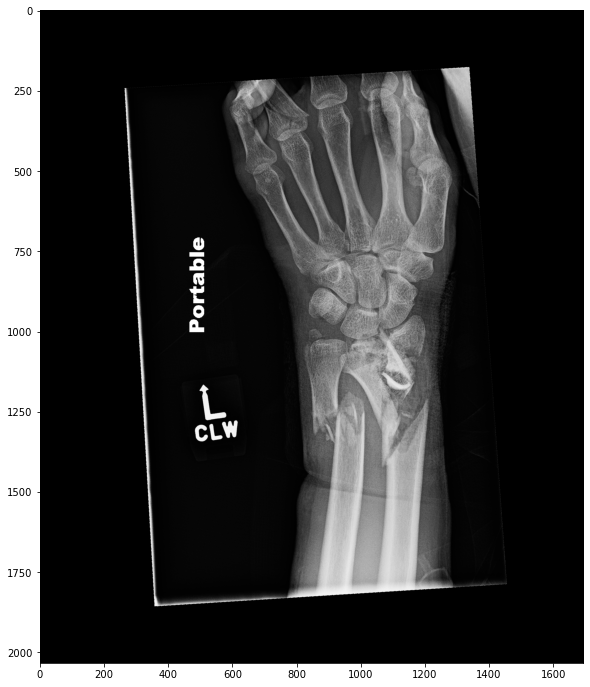

In [35]:
img1 = read_xray('Images\Subject002\IMediaExport\DICOM\PAT_0000\STD_0000\SER_0000\OBJ_0001\IM_0001')
plt.figure(figsize = (12,12))
plt.imshow(img1, 'gray')

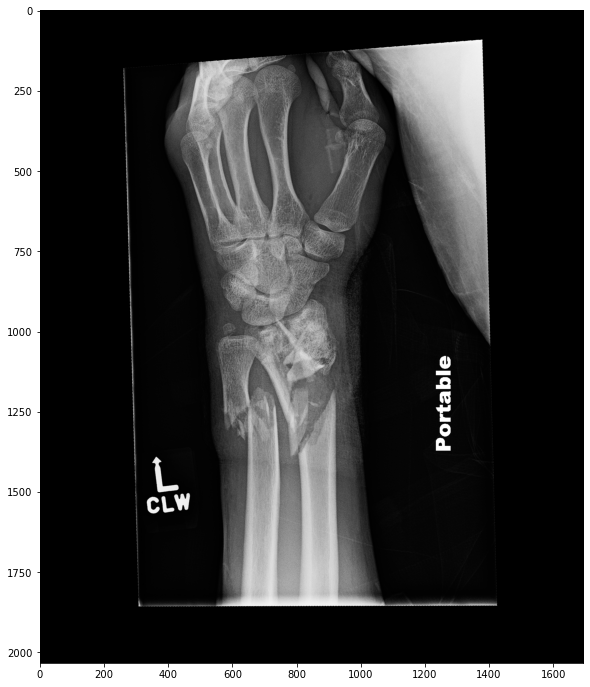

In [37]:
img2 = read_xray('Images\Subject002\IMediaExport\DICOM\PAT_0000\STD_0000\SER_0001\OBJ_0001\IM_0001')
plt.figure(figsize = (12,12))
plt.imshow(img2, 'gray')

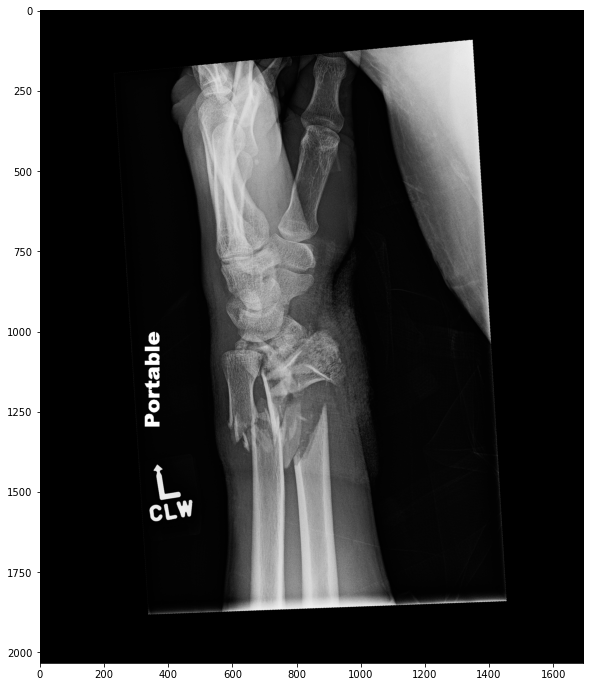

In [38]:
img3 = read_xray('Images\Subject002\IMediaExport\DICOM\PAT_0000\STD_0000\SER_0002\OBJ_0001\IM_0001')
plt.figure(figsize = (12,12))
plt.imshow(img3, 'gray')

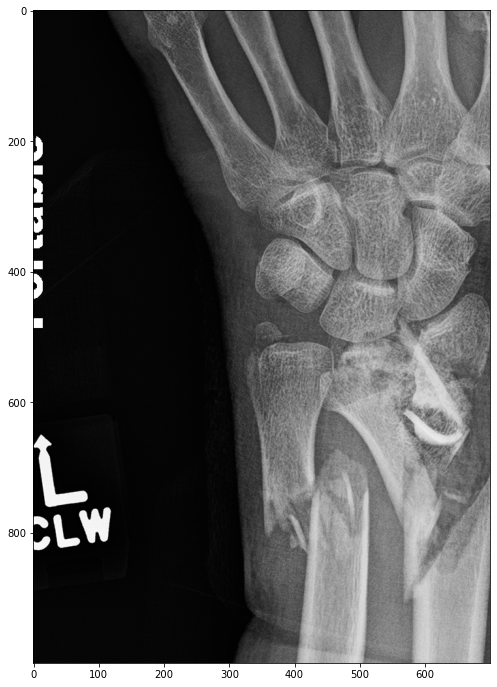

In [39]:
x1 = img1.shape
img1cr = img1[np.round(x1[0]/2).astype(int)-500:np.round(x1[0]/2).astype(int)+500, 
              np.round(x1[1]/2).astype(int)-350:np.round(x1[1]/2).astype(int)+350]
plt.figure(figsize = (12,12))
plt.imshow(img1cr, 'gray')

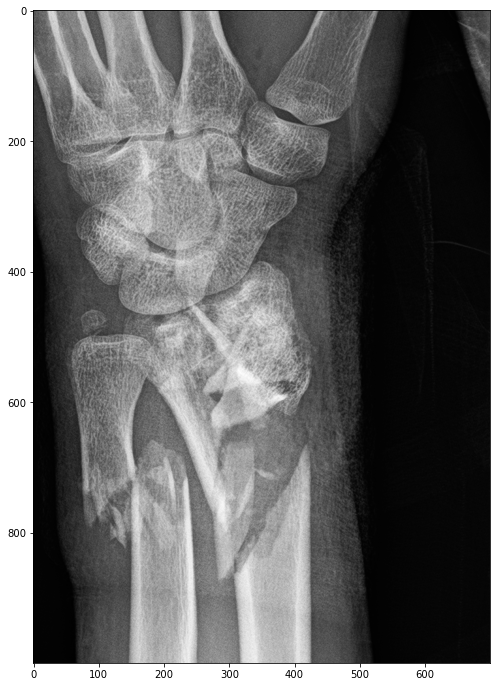

In [40]:
x2 = img2.shape
img2cr = img2[np.round(x2[0]/2).astype(int)-500:np.round(x2[0]/2).astype(int)+500, 
              np.round(x2[1]/2).astype(int)-350:np.round(x2[1]/2).astype(int)+350]
plt.figure(figsize = (12,12))
plt.imshow(img2cr, 'gray')

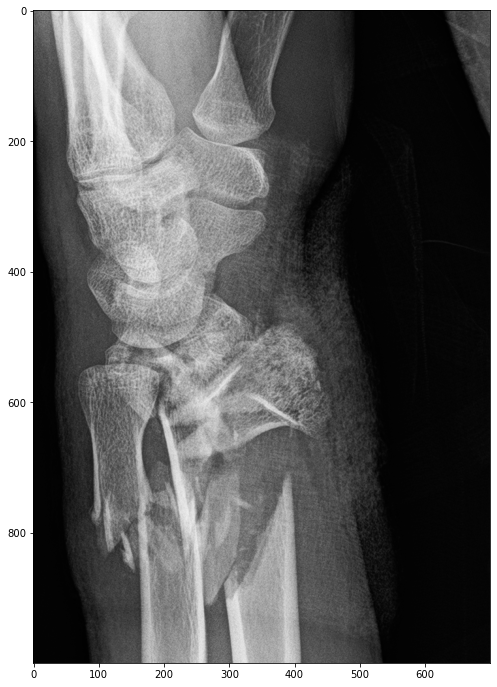

In [41]:
x3 = img3.shape
img3cr = img3[np.round(x3[0]/2).astype(int)-500:np.round(x3[0]/2).astype(int)+500, 
              np.round(x3[1]/2).astype(int)-350:np.round(x3[1]/2).astype(int)+350]
plt.figure(figsize = (12,12))
plt.imshow(img3cr, 'gray')

In [42]:
ComboView = np.append(img1cr, img2cr, axis=1)
ComboView = np.append(ComboView, img3cr, axis=1)
ComboView.shape

(1000, 2100)

<function matplotlib.pyplot.show(close=None, block=None)>

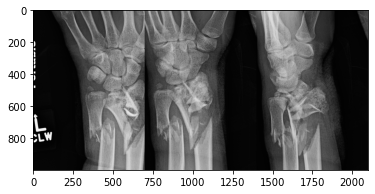

In [43]:
plt.imshow(ComboView, cmap='gray')  
plt.show

In [44]:
ComboReduce = np.zeros((500, 1050))
ComboReduce.shape

(500, 1050)

In [45]:
ComboViewN = ComboView/255

In [46]:
for k in range(500):
    for i in range(1050):
        ComboReduce[k,i] = round((ComboViewN[2*k,2*i]+ComboViewN[2*k+1,2*i]+
                                    ComboViewN[2*k, 2*i+1]+ComboViewN[2*k+1,2*i+1])/4)           

In [47]:
np.max(ComboReduce)

1.0

In [48]:
ComboReduce = np.reshape(ComboReduce,(1,500,1050,1))

In [49]:
# load json and create model
json_file = open('model20211129a.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model20211129a.h5")
print("Loaded model from disk")
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


In [50]:
predict_x=loaded_model.predict(ComboReduce)
classes_x=np.argmax(predict_x,axis=1)
if classes_x==0:
    print("Type of fracture is I")
else:
    if classes_x==1:
        print("Type of fracture is II")
    else:
        print("Type of fracture is III")
print("Type I:   ", round(predict_x[0,0]*100,2))
print("Type II:  ", round(predict_x[0,1]*100,2))
print("Type III: ", round(predict_x[0,2]*100,2))

Type of fracture is III
Type I:    0.0
Type II:   0.0
Type III:  100.0
